# Mean Reversion Trading Strategy with GLD and USO

This Python code implements a mean-reversion trading strategy using two financial assets: GLD (a gold ETF) and USO (an oil ETF). The strategy attempts to exploit deviations between the price movements of these two assets, assuming their prices will revert to a mean over time.

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Annual Percentage Rate (APR): -0.99%
Sharpe Ratio: -0.05


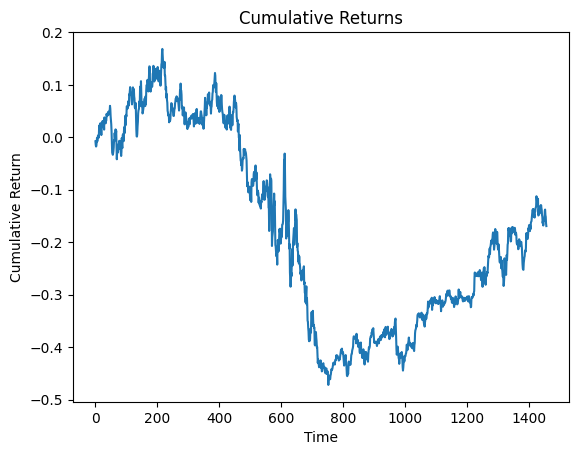

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf

# Download data for GLD and USO
x = yf.download("GLD", start="2006-05-24", end="2012-04-09")["Adj Close"].values
y = yf.download("USO", start="2006-05-24", end="2012-04-09")["Adj Close"].values

# Use the actual length of the data
T = len(x)

# Lookback period for hedge ratio calculation
lookback = 11

# Hedge ratio calculation using OLS (Ordinary Least Squares)
hedge_ratio = np.full(T, np.nan)

for t in range(lookback, T):
    if np.std(x[t-lookback:t]) > 1e-8:
        X = sm.add_constant(x[t-lookback:t])
        model = sm.OLS(y[t-lookback:t], X)
        results = model.fit()
        if len(results.params) > 1:
            hedge_ratio[t] = results.params[1]
    else:
        hedge_ratio[t] = np.nan  # Handle case where x has no variation

# Fill forward any remaining NaNs in the hedge_ratio
hedge_ratio = pd.Series(hedge_ratio).ffill().values

# Calculate the spread: USO - hedgeRatio * GLD
yport = y - hedge_ratio * x

# Moving average and standard deviation for mean-reversion strategy
def moving_avg(series, window):
    return series.rolling(window=window).mean()

def moving_std(series, window):
    return series.rolling(window=window).std()

# Ensure yport has no NaNs in the initial period
yport = pd.Series(yport).dropna()

# Calculate z-score based on moving average and std deviation
z_score = (yport - moving_avg(yport, lookback)) / moving_std(yport, lookback)
z_score = z_score.dropna()

# Calculate the number of units to hold in the portfolio based on the z-score
num_units = -z_score

# Align x, y, and hedge_ratio with the length of num_units
x = x[-len(num_units):]
y = y[-len(num_units):]
hedge_ratio = hedge_ratio[-len(num_units):]

# Calculate the positions
positions = np.column_stack([num_units * hedge_ratio, -num_units]) * np.column_stack([x, y])

# Daily P&L: roll positions and adjust for price changes
pnl = np.sum(np.roll(positions, 1, axis=0) * (np.column_stack([x, y]) - np.roll(np.column_stack([x, y]), 1, axis=0)) / np.roll(np.column_stack([x, y]), 1, axis=0), axis=1)

# Remove the first day's P&L since np.roll introduces an artificial shift
pnl = pnl[1:]

# Daily returns: P&L divided by the gross market value of the portfolio
gross_market_value = np.sum(np.abs(np.roll(positions, 1, axis=0)), axis=1)[1:]
returns = pnl / gross_market_value

# Remove NaNs from returns
returns = returns[~np.isnan(returns)]

# Calculate cumulative returns, annualized return (APR), and Sharpe ratio
cumulative_returns = np.cumprod(1 + returns) - 1
apr = np.mean(returns) * 252  # Assuming 252 trading days in a year
sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)

# Output APR and Sharpe ratio
print(f"Annual Percentage Rate (APR): {apr:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Plot cumulative returns
plt.plot(cumulative_returns)
plt.title('Cumulative Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.show()
